# **Import Libraries**

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import glob as gb
import cv2
import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

# Model
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam

# Model Checks
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import itertools


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

2024-02-26 20:59:16.042664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 20:59:16.042812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 20:59:16.197839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Forming datasets

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.3)
# Training and validation dataset
train = datagen.flow_from_directory('/kaggle/input/tomatoleaf/tomato/train', seed=123, subset='training' )
val = datagen.flow_from_directory('/kaggle/input/tomatoleaf/tomato/train', seed=123, subset='validation' )

# Test dataset for evaluation
datagen2 = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test = datagen2.flow_from_directory('/kaggle/input/tomatoleaf/tomato/val' , shuffle=False)

Found 7000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [3]:
def show_samples(gen, classes):
    num_classes = len(classes)

    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()

    for class_index in range(num_classes):
        images, labels = next(gen)
        class_images = images[0]
        class_name = classes[class_index]

        axes[class_index].imshow(class_images)
        axes[class_index].set_title(class_name, color='blue', fontsize=12)
        axes[class_index].axis('off')

    plt.tight_layout()
    plt.show()
    

In [4]:
import os
classes = os.listdir('/kaggle/input/tomatoleaf/tomato/train')

In [5]:
classes

['Tomato___Late_blight',
 'Tomato___healthy',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Leaf_Mold',
 'Tomato___Spider_mites Two-spotted_spider_mite']

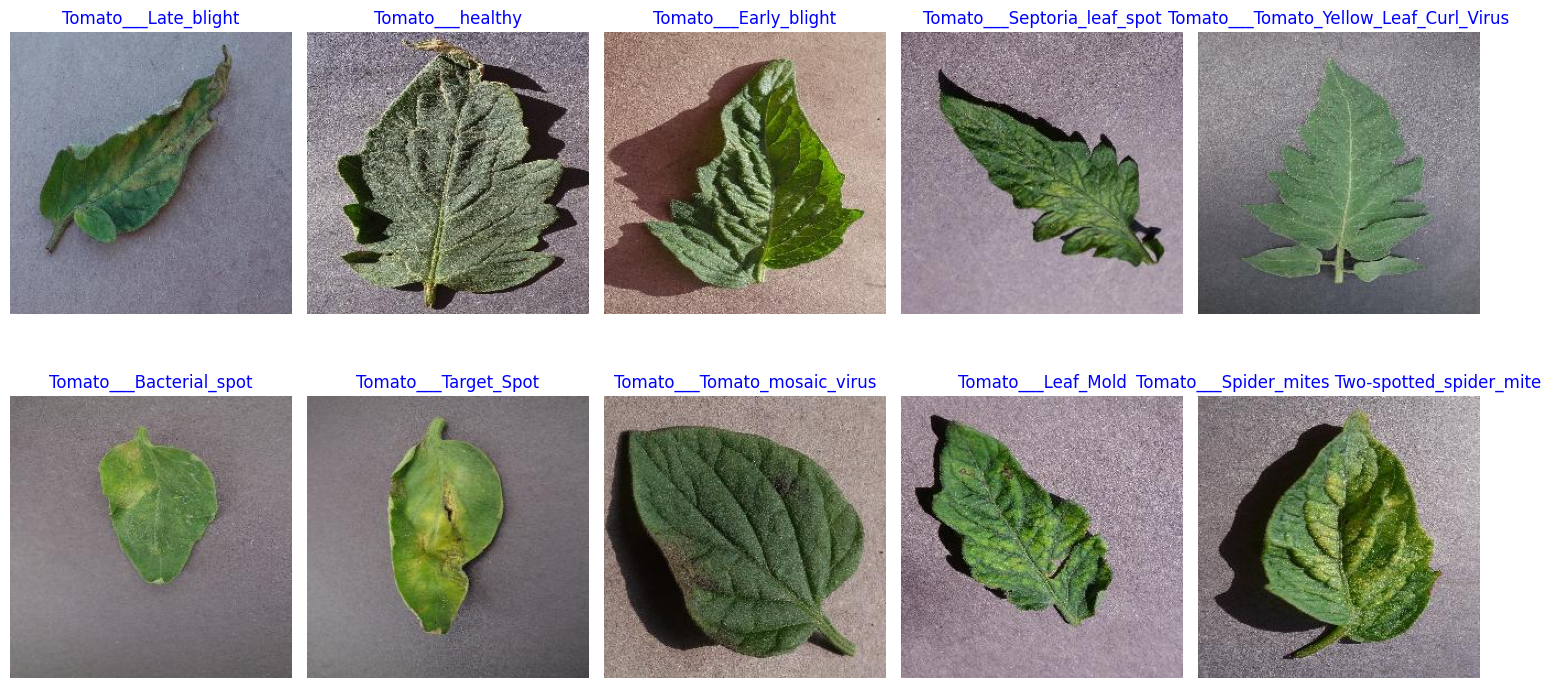

In [6]:
show_samples(train, classes)

# **Proposed Model**

In [7]:
# Squeeze-and-Excitation (SE) block
def se_block(inputs, reduction_ratio=16):
    channels = inputs.shape[-1]  # Get the number of channels using TensorFlow's shape function
    se = GlobalAveragePooling2D()(inputs)
    se = Dense(channels // reduction_ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = tf.expand_dims(se, axis=1)
    se = tf.expand_dims(se, axis=1)
    return inputs * se

In [8]:
image_size = 256
num_classes = 10

# Function to initialize model (ResNet152V2)
def get_model():
    
    base_model = ResNet152V2(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = se_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model

model = get_model()

234545216/234545216 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [10]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(train, steps_per_epoch=len(train),validation_data=val,
                    validation_steps=len(val), epochs=50, verbose=1 , callbacks=[es])

Epoch 1/50


I0000 00:00:1708981231.377575      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - 158s 498ms/step - loss: 1.0277 - accuracy: 0.7269 - val_loss: 0.2194 - val_accuracy: 0.9310
Epoch 2/50
219/219 [==============================] - 102s 466ms/step - loss: 0.1697 - accuracy: 0.9530 - val_loss: 0.1479 - val_accuracy: 0.9550
Epoch 3/50
219/219 [==============================] - 102s 465ms/step - loss: 0.0550 - accuracy: 0.9859 - val_loss: 0.1133 - val_accuracy: 0.9610
Epoch 4/50
219/219 [==============================] - 102s 465ms/step - loss: 0.0270 - accuracy: 0.9934 - val_loss: 0.0940 - val_accuracy: 0.9683
Epoch 5/50
219/219 [==============================] - 102s 465ms/step - loss: 0.0185 - accuracy: 0.9963 - val_loss: 0.0905 - val_accuracy: 0.9703
Epoch 6/50
219/219 [==============================] - 102s 465ms/step - loss: 0.0138 - accuracy: 0.9970 - val_loss: 0.0938 - val_accuracy: 0.9707
Epoch 7/50
219/219 [==============================] - 102s 466ms/step - loss: 0.0120 - accuracy: 0.9969 - val_loss: 0.0872 - val_accura

In [12]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict_generator(test)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 10)

y_test= to_categorical(test.labels, 10)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

# **Evaluate Model Accuracy , Precision , Recall , F1-Score , AUC**

In [13]:
# check whether the model is best fit for the given problem and corresponding data , Evaluate the model on the test data
def evaluate_model (test):
    results = model.evaluate_generator(test)
    return results


**Accuracy**

In [14]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

**Percision**

In [15]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

**Recall**

In [16]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

**F1-Score**

In [17]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

**AUC**

In [18]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average="micro"):
    # Making a set of all the unique classes
    unique_class = set(actual_class)
    roc_auc_dict = {}
    total_auc = 0  # Variable to store the total AUC score

    for per_class in unique_class:
        # Making a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        # Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc
        total_auc += roc_auc

    # Calculating the average AUC score for all classes
    average_auc = total_auc / len(unique_class)

    return roc_auc_dict, average_auc

# **Model Performance**

In [19]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , evaluate_model(test)) 
print("******************************")
print("Accuracy  : " , Accuracy(test.classes , y_pred1)) 
print("******************************")
print("Precision Score is : " , macro_precision(test.classes , y_pred1))
print("******************************")
print("Recall Scores is : " , macro_recall(test.classes , y_pred1))
print("******************************")
print('F1 Score is : ', macro_F1Score(test.classes , y_pred1))
print("******************************")
roc_auc_dict, average_auc = AUC(test.classes, y_pred1)
print('AUC Score for each class  : ' , roc_auc_dict)
print('AUC Average Score   : ' , average_auc)

***** Model Evaluations Details ******** 

Test loss, Test acc :  [0.1736801266670227, 0.9470000267028809]
******************************
Accuracy  :  0.947
******************************
Precision Score is :  0.9484277882082237
******************************
Recall Scores is :  0.9470000000000001
******************************
F1 Score is :  0.9468653187598338
******************************
AUC Score for each class  :  {0: 0.9883333333333334, 1: 0.9383333333333335, 2: 0.9772222222222222, 3: 0.995, 4: 0.9694444444444446, 5: 0.9488888888888888, 6: 0.9172222222222222, 7: 0.9844444444444445, 8: 0.9972222222222222, 9: 0.9894444444444445}
AUC Average Score   :  0.9705555555555557


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test1, y_pred1, target_names=classes))

                                               precision    recall  f1-score   support

                         Tomato___Late_blight       0.97      0.98      0.98       100
                             Tomato___healthy       0.88      0.89      0.89       100
                        Tomato___Early_blight       0.87      0.97      0.92       100
                  Tomato___Septoria_leaf_spot       1.00      0.99      0.99       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.90      0.95      0.93       100
                      Tomato___Bacterial_spot       0.98      0.90      0.94       100
                         Tomato___Target_Spot       0.94      0.84      0.89       100
                 Tomato___Tomato_mosaic_virus       0.99      0.97      0.98       100
                           Tomato___Leaf_Mold       0.95      1.00      0.98       100
Tomato___Spider_mites Two-spotted_spider_mite       0.99      0.98      0.98       100

                                     accu

# **Model Graphs ROC Curve , Accuracy , Loss , Confusion Matrix , TSNE**

plot_roc_curve copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [21]:
def plot_roc_curve(y_test,y_pred):
    n_classes=10
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'
                   ])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate" , weight='bold')
    plt.ylabel("True Positive Rate" , weight='bold')
    plt.title("Proposed-Model-Roc-Curve" , weight='bold')
    plt.legend(loc="lower right")

    plt.show()
    


In [22]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Proposed-Model Accuracy' , weight='bold')
    plt.xlabel('Epochs' , weight='bold')
    plt.ylabel('Accuracy' , weight='bold')
    plt.legend()
    plt.show()

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Proposed-Model Loss' , weight='bold')
    plt.xlabel('Epochs' , weight='bold')
    plt.ylabel('loss' , weight='bold')
    plt.legend()
    plt.show()
    

In [23]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title , weight='bold')
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('Actual Label' , weight='bold')
	plt.xlabel('Predicted Label' , weight='bold')

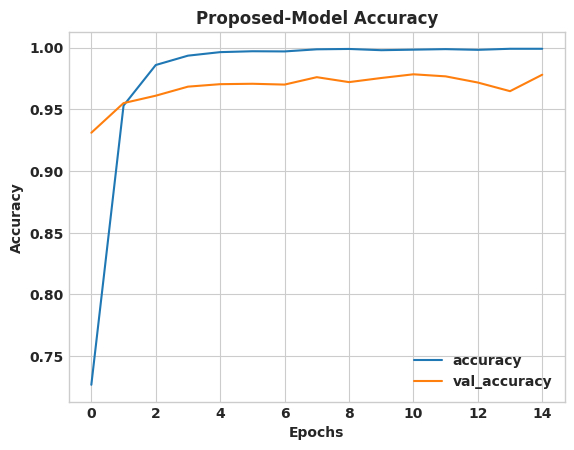

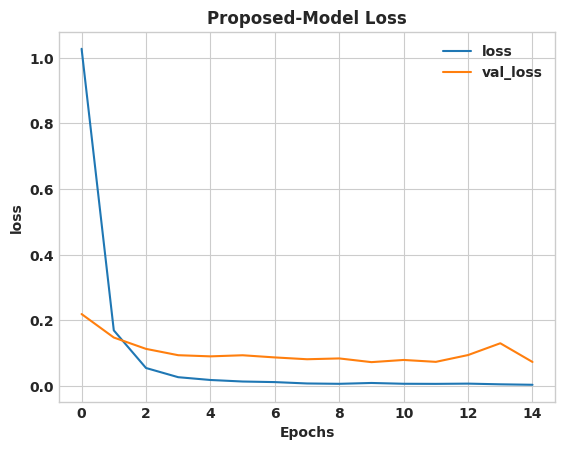

In [24]:
Acc_Loss_Graph(history)

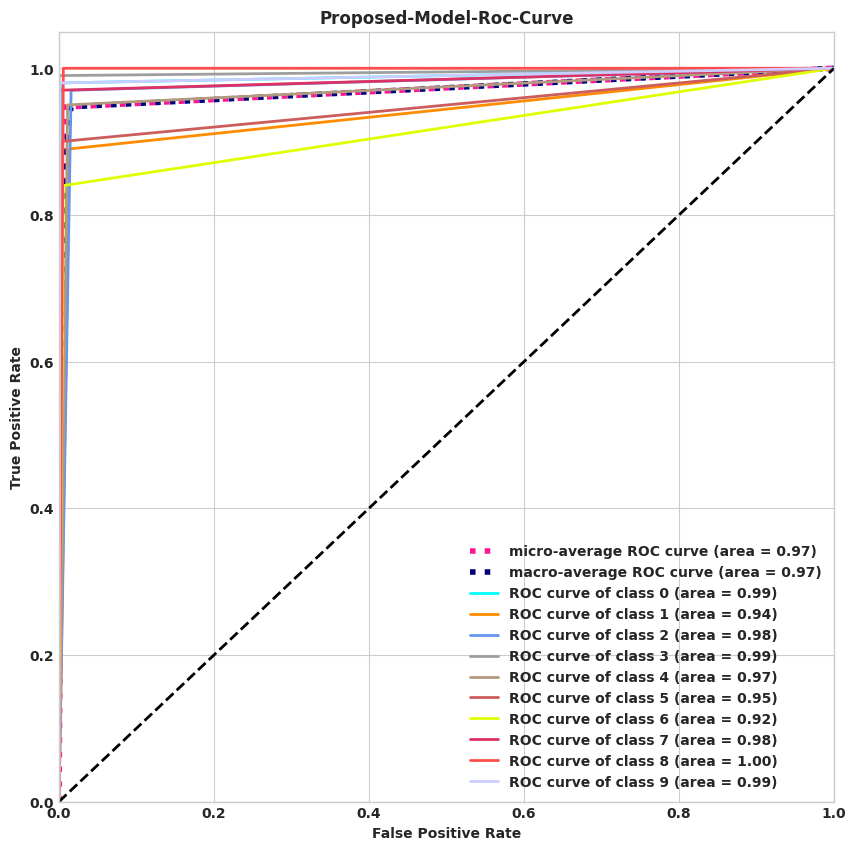

In [25]:
plot_roc_curve(y_test,y_pred2)

Confusion Matrix, Without Normalization
[[ 98   0   0   0   1   0   0   1   0   0]
 [  0  89   8   0   3   0   0   0   0   0]
 [  0   3  97   0   0   0   0   0   0   0]
 [  0   0   0  99   1   0   0   0   0   0]
 [  1   3   1   0  95   0   0   0   0   0]
 [  0   0   2   0   0  90   5   0   3   0]
 [  0   6   3   0   4   2  84   0   0   1]
 [  2   0   0   0   0   0   0  97   1   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   1   0   0   0   1  98]]


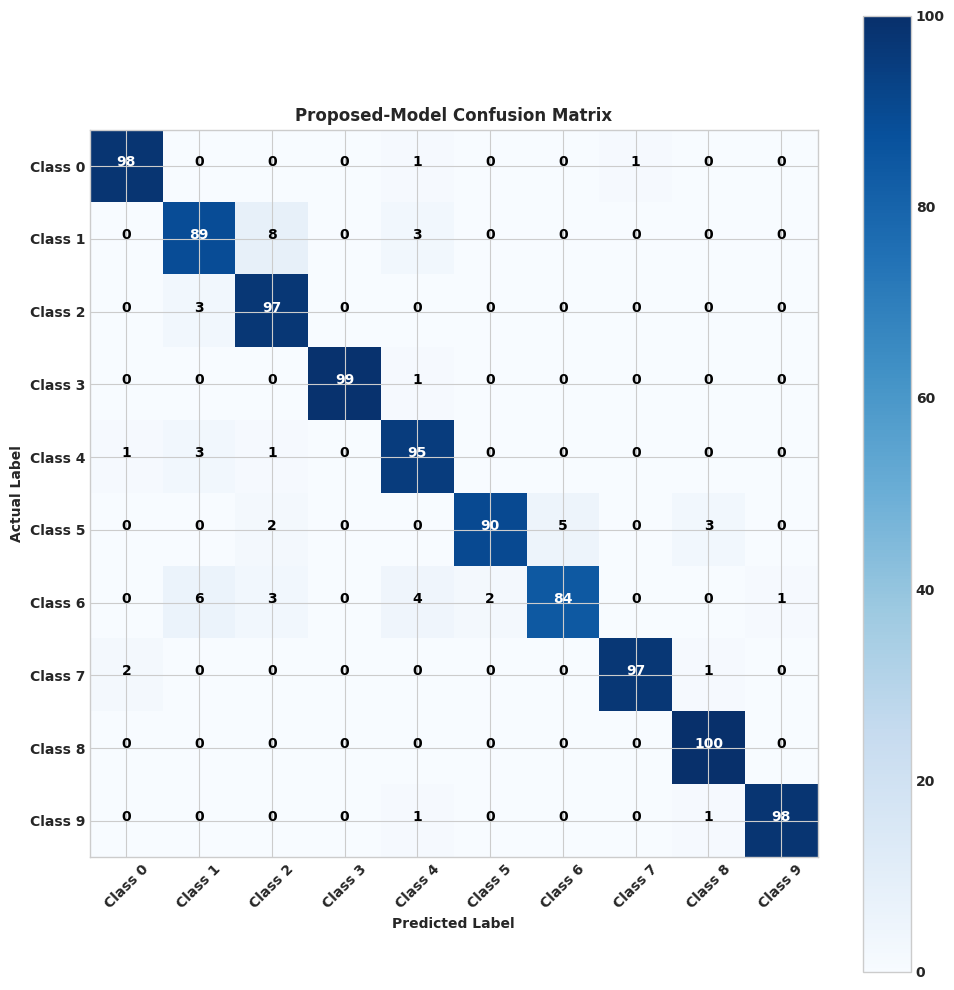

In [26]:
classes=np.array(["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9"])

# Convert y_pred to discrete class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(test.classes, y_pred_labels)

# Plot confusion matrix
plot_confusion_matrix(cm=cm, classes=classes, title='Proposed-Model Confusion Matrix')

In [27]:
target_name = {0:'Tomato___Late_blight',
               1: 'Tomato___healthy',
               2: 'Tomato___Early_blight',
               3: 'Tomato___Septoria_leaf_spot',
               4: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
               5: 'Tomato___Spider_mites',
               6: 'Tomato___Target_Spot',
               7: 'Tomato___Tomato_mosaic_virus',
               8: 'Tomato___Leaf_Mold',
               9: 'Tomato___Spider_mites Two-spotted_spider_mite'}

In [28]:
from sklearn.manifold import TSNE
tsne2 = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred)

In [29]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((tsne2, 
                                            y_test1)))# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)

In [30]:
cps_df.loc[:, 'target'] = cps_df.target.map(target_name)

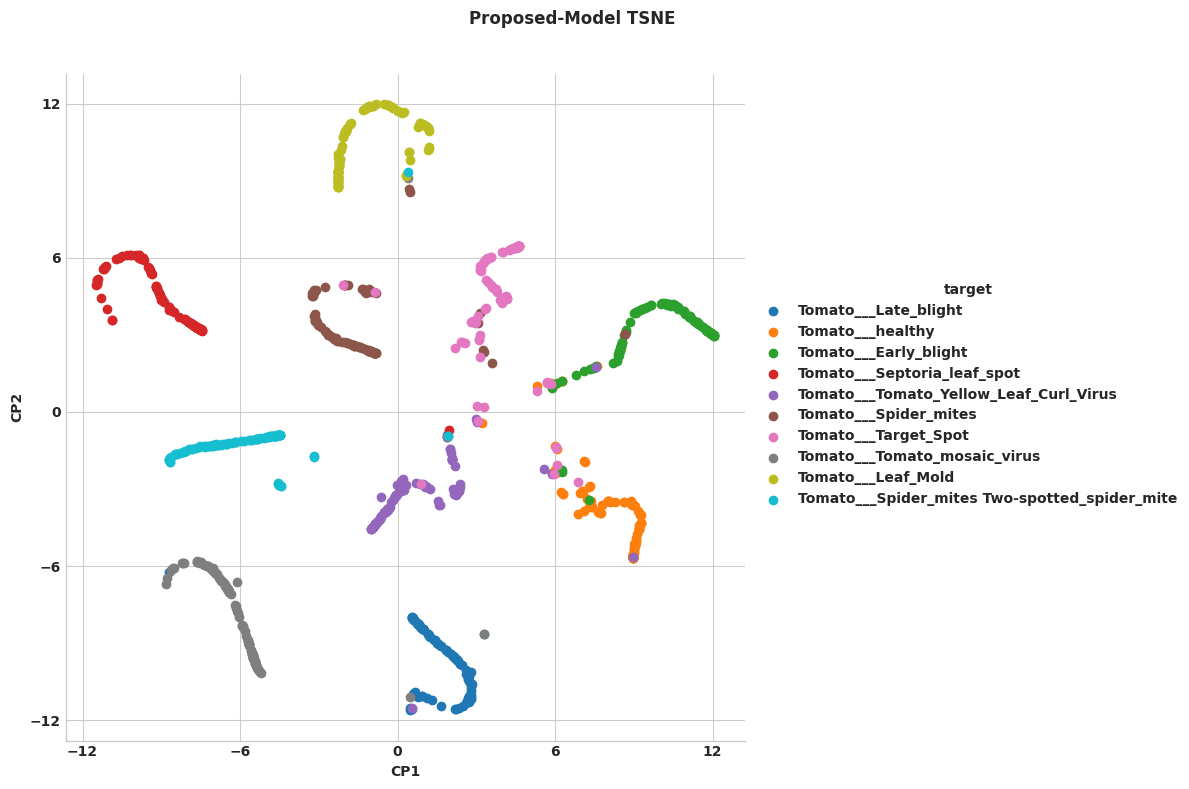

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

grid = sns.FacetGrid(cps_df, hue="target", height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()

# Add title to the FacetGrid plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Proposed-Model TSNE', fontweight='bold')

# Set x-label and y-label with bold font
for ax in grid.axes.flat:
    ax.set_xlabel('CP1', fontweight='bold')
    ax.set_ylabel('CP2', fontweight='bold')

# Set tick labels with numbers on the x-axis and y-axis
for ax in grid.axes.flat:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

plt.show()

In [32]:
model.save("/kaggle/working/Proposed_Model_Tomato.h5")